<h1>Common Traits of US Presidents</h1>

The scope of this notebook is to compare and examine correlations among all Presidents of the United States (POTUS) since the country's inception. **First, a dataset is created from multiple webpages**. Presidents demographic information and historian scores/rankings are gathered. 

Historian scores are determined by anonymously surveying 142 academics in 2021. This includes historians, professors and other professional observers of the presidency. Since 2000, the survey has been conducted soon after there has been a change in the administration. Survey participants are given a list of ten presidential leadership characteristics in which they interpret them as they see fit, rating each president on a 1-10 scale. These ten presidential qualities are:

* Administrative Skills
* Crisis Leadership
* Economic Management
* International Relations
* Moral Authority
* Performance Within Context of Times
* Public Persuasion
* Pursued Equal Justice For All
* Relations with Congress
* Vision / Setting an Agenda

Each of the ten categories is given equal weighting in arriving at a president's Overall Historian Score ([source](https://www.c-span.org/presidentsurvey2021/?page=methodology)). Joe Biden was not assigned a historian score due to his ongoing term. **After the data is scraped, it is prepared for visualizations**. Approaches taken when visualizing the POTUS dataset:

* Compare all presidents.
* Look for trends among presidents from both democratic and republican parties.

If you would like to explore how sibling relationships correlate with historian scores feel free to check out the [tableau dashboard](https://public.tableau.com/views/USPresidentsScores/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link) I made. Observations have no personal political significance. 

In [1]:
import pandas as pd
import requests
import re
from time import sleep
import seaborn as sns
import matplotlib.pylab as plt



def scrape_html_table(url, index=0):
    assert isinstance(url, str)

    source = requests.get(url).text
    df = pd.read_html(source)[index]

    return df


#Sort dataframe by president term order
def sort_scraped_df(df, column_label):
    assert isinstance(df, pd.DataFrame)
    assert isinstance(column_label, str)

    df[column_label] = df[column_label].map(int)      
    df.sort_values(column_label, inplace=True)
    df.reset_index(inplace=True, drop=True)

    return df


#Configure the order of categorical values in a dataframe column
def ordered_cat_col(df, ordered_list, column_name):
    assert isinstance(df, pd.DataFrame)
    assert isinstance(ordered_list, list)
    assert isinstance(column_name, str)

    df[column_name] = pd.Categorical(df[column_name],
                                    categories=ordered_list,
                                    ordered=True)
    return df

<h3>Webscraping: Presidents and Amount of Siblings</h3>



In [2]:
url = 'https://www.potus.com/presidential-facts/birth-order/'

potusData = scrape_html_table(url)

#Initialize column
potusData['Birth Order'] = None

#Fill column with values
potusData.iloc[1:12, potusData.columns.get_loc('Birth Order')] = 'First Born'
potusData.iloc[13:27, potusData.columns.get_loc('Birth Order')] = 'Second Born'
potusData.iloc[28:35, potusData.columns.get_loc('Birth Order')] = 'Third Born'
potusData.iloc[36:39, potusData.columns.get_loc('Birth Order')] = 'Fourth Born'
potusData.iloc[40:43, potusData.columns.get_loc('Birth Order')] = 'Fifth Born'
potusData.iloc[44:48, potusData.columns.get_loc('Birth Order')] = 'Sixth Born'
potusData.iloc[49:, potusData.columns.get_loc('Birth Order')] = 'Seventh Born'

#Drop extra rows
potusData.drop(index=[0, 12, 27, 35, 39, 43, 48], inplace=True)


#Grover Cleveland edge case
potusData.at[42, '#'] = 22



#Determine if president is the youngest sibling
potusData['# Siblings'] = potusData['# Siblings'].map(str)
potusData['Youngest Sibling?'] = ['Yes' if ' *' in total else 'No' for total in potusData['# Siblings']]

#Remove youngest indicator
potusData['# Siblings'] = potusData['# Siblings'].map(lambda x: re.sub(r'\s\S', '', x))
potusData['# Siblings'] = potusData['# Siblings'].map(int)



#Rename and drop columns
potusData.rename(columns={'#': 'President ID', '# Siblings': 'Total Siblings'}, inplace=True)
potusData.drop(columns=['Unnamed: 0', '# Presidents'], inplace=True)

#Sort by term order
potusData['President ID'] = potusData['President ID'].map(int)
potusData.sort_values('President ID', inplace=True)
potusData.reset_index(drop=True, inplace=True)

Preview of scraped data:

In [3]:
potusData.head()

,President ID,President,Total Siblings,Birth Order,Youngest Sibling?
0,1,George Washington,10,Sixth Born,No
1,2,John Adams,2,First Born,No
2,3,Thomas Jefferson,9,Third Born,No
3,4,James Madison,11,First Born,No
4,5,James Monroe,4,Second Born,No


<h3>Webscraping: Years in Office & Executive Orders Issued</h3>

In [4]:
#Executive orders
url = 'https://en.m.wikipedia.org/wiki/List_of_United_States_federal_executive_orders#Consolidated_list_by_president'

df = scrape_html_table(url, index=1)

#Edge case - President Grover Cleveland has two non-consecutive presidencies 

#Manually update values
df.at[21, 'Total executive orders'] = 253
df.at[21, 'Years in office']= 8
df.at[21, 'Executive orders per year'] = 31.6

#Drop duplicate president
df.drop(index=23, inplace=True)

df.at[21, 'President'] = 'Grover Cleveland'


df.reset_index(inplace=True, drop=True)
df.rename(columns={'#':'President ID'}, inplace=True)


column_names = ['President ID', 'Party', 'Total executive orders', 
                'Years in office', 'Executive orders per year']

potusData = pd.merge(potusData, df[column_names], on='President ID', how='left')

Preview of scraped data:

In [5]:
potusData[column_names].head()

,President ID,Party,Total executive orders,Years in office,Executive orders per year
0,1,Unaffiliated,8,7.95,1.0
1,2,Federalist,1,4.00,0.3
2,3,Democratic-Republican,4,8.00,0.5
3,4,Democratic-Republican,1,8.00,0.1
4,5,Democratic-Republican,1,8.00,0.1


We will now take the years in office for each president and distribute them into five categories: 
* 1 Partial Term
* 1 Full Term
* Partial/Full Terms (one partial and one full term, and viceversa)
* 2 Full Terms
* 3 Full Terms and 1 Partial Term (only applies to Franklin D Roosevelt)

In [6]:
#George Washington served 2 terms instead of 7.95
potusData.at[0, 'Years in office'] = 8

terms_in_office = ['1 Partial Term' if yrs < 4.00 
                    else '1 Full Term' if yrs == 4.00 
                    else 'Partial/Full Terms' if (yrs > 4.00 and yrs < 8.00)
                    else '2 Full Terms' if yrs == 8.00
                    else '3+ Terms' for yrs in potusData['Years in office']]


potusData['Total terms'] = terms_in_office

potusData['Total terms'].head()

0    2 Full Terms
1     1 Full Term
2    2 Full Terms
3    2 Full Terms
4    2 Full Terms
Name: Total terms, dtype: object

<h3>Webscraping: Birthplaces of Presidents</h3>

In [7]:
#This url has three tables: we will use the 1st table called Presidents
url = 'https://www.britannica.com/place/United-States/Presidents-of-the-United-States'

df = scrape_html_table(url)[:46]

#Grover Cleveland edge case (removing duplicate entry)
df.drop(index=23, inplace=True)
df.reset_index(inplace=True, drop=True)

#We only need birthplace column, remove all other columns
df.drop(labels=['Unnamed: 0', 'no.', 'political party', 'term', 'president'],
                axis=1, inplace=True)


#Write complete name of states
df.loc[(df.birthplace == 'Va.'), 'birthplace'] = 'Virginia'
df.loc[(df.birthplace == 'Mass.'), 'birthplace'] = 'Massachusetts'
df.loc[(df.birthplace == 'S.C.'), 'birthplace'] = 'South Carolina'
df.loc[(df.birthplace == 'N.Y.'), 'birthplace'] = 'New York'
df.loc[(df.birthplace == 'N.C.'), 'birthplace'] = 'North Carolina'
df.loc[(df.birthplace == 'N.H.'), 'birthplace'] = 'New Hampshire'
df.loc[(df.birthplace == 'Pa.'), 'birthplace'] = 'Pennsylvania'
df.loc[(df.birthplace == 'Ky.'), 'birthplace'] = 'Kentucky'
df.loc[(df.birthplace == 'Vt.'), 'birthplace'] = 'Vermont'
df.loc[(df.birthplace == 'Mo.'), 'birthplace'] = 'Montana'
df.loc[(df.birthplace == 'N.J.'), 'birthplace'] = 'New Jersey'
df.loc[(df.birthplace == 'Calif.'), 'birthplace'] = 'California'
df.loc[(df.birthplace == 'Neb.'), 'birthplace'] = 'Nebraska'
df.loc[(df.birthplace == 'Ark.'), 'birthplace'] = 'Arkansas'
df.loc[(df.birthplace == 'Ill.'), 'birthplace'] = 'Illinois'
df.loc[(df.birthplace == 'Conn.'), 'birthplace'] = 'Connecticut'
df.loc[(df.birthplace == 'Ga.'), 'birthplace'] = 'Georgia'

#Add to dataframe
potusData = potusData.join(df.birthplace)
potusData.rename(columns={'birthplace': 'Birthplace'}, inplace=True)

Preview of scraped data:

In [8]:
potusData['Birthplace'].head()

0         Virginia
1    Massachusetts
2         Virginia
3         Virginia
4         Virginia
Name: Birthplace, dtype: object

<h3>Webscraping: Presidents Overall Historian Score Survey Results</h3>

In [9]:
#Main table
#   Desired columns to scrape: 'President' and '2021 Final Score'
#   Bill Clinton doesn't show up on website but is included in their pdf report.
#       Link to pdf 2021 report: 
#       https://static.c-span.org/assets/documents/presidentSurvey/2021-Survey-Results-Overall.pdf
#   Joe Biden does not show because his presidency is ongoing.


url = 'https://www.c-span.org/presidentsurvey2021/?page=overall' 

df = scrape_html_table(url)

#CLEAN THE DATAFRAME
#Remove first two rows.
df.drop(index=[0, 1], inplace=True)
#Rename columns
df.rename(columns={0: 'President', 1: 'Overall Historian Score'}, inplace=True)
#Remove extra columns
df.drop(labels=[2,3,4,5], axis=1, inplace=True)


#Presidents are ordered by their score in the website.
#   Before merging the tables, the names of the presidents need to match. 
potusData.at[23, 'President'] = 'William McKinley'
potusData.at[39, 'President'] = 'George H. W. Bush'
potusData.at[25, 'President'] = 'William Howard Taft'


#   Then we sort dataframe based on a column in another dataframe
df = df.set_index('President')
df = df.reindex(index=potusData['President'])
df = df.reset_index()

#Bill Clinton edge case: manually add score
df.at[40, 'Overall Historian Score'] = 594

potusData = potusData.merge(df, on='President')

Preview of scraped data:

In [10]:
potusData['Overall Historian Score'].head()

0    851
1    609
2    704
3    604
4    643
Name: Overall Historian Score, dtype: object

<h3>Webscraping: 10 Qualities of Presidential Leadership Survey Results</h3>

In [11]:
#Change last digit of url up to 10 with a loop.
url = 'https://www.c-span.org/presidentsurvey2021/?category=1'

#Each of the 10 columns are located in a different link.
column_names = ['Public Persuasion Score', 'Crisis Leadership Score', 'Economic Management Score', 
                'Moral Authority Score', 'International Relations Score','Administrative Skills Score', 
                'Relations with Congress Score', 'Vision / Setting an Agenda Score', 
                'Pursued Equal Justice For All Score', 'Performance Within Context of Times Score']

#Bill Clinton Edge Case. Manually add scores from pdf file.
clinton_scores = [73.4, 57.7, 73.6, 30.0, 58.7, 59.4, 52.2, 60.2, 66.6, 61.9]

#Scrape data and append columns to dataframe
i = 0
for col in column_names:
    #Make link
    i += 1
    url = url[:-1] + str(i)

    df = scrape_html_table(url)

    #Remove first two rows.
    df.drop(index=[0, 1], inplace=True)

    #Rename columns
    df.rename(columns={0: 'President', 1: col}, inplace=True)

    #Remove extra columns
    df.drop(labels=[2,3,4,5, 6], axis=1, inplace=True)

    #   Then we sort dataframe based on a column in another dataframe
    df = df.set_index('President')
    df = df.reindex(index=potusData['President'])
    df = df.reset_index()

    potusData = potusData.merge(df, on='President')

    sleep(1.5)

#Bill Clinton edge case. Add to dataframe
for score, col in zip(clinton_scores, column_names):
    potusData.at[40, col] = score

Preview of scraped data:

In [12]:
potusData[column_names].head()

,Public Persuasion Score,Crisis Leadership Score,Economic Management Score,Moral Authority Score,International Relations Score,Administrative Skills Score,Relations with Congress Score,Vision / Setting an Agenda Score,Pursued Equal Justice For All Score,Performance Within Context of Times Score
0,89.9,91.9,80.5,92.7,85.0,84.0,83.5,93.1,54.8,95.6
1,51.4,62.2,63.9,71.6,66.2,61.2,52.9,59.2,57.3,63.0
2,79.6,70.2,62.4,69.1,69.2,72.1,73.0,83.8,47.9,77.1
3,60.5,60.4,57.1,68.5,56.0,62.0,60.9,66.4,47.1,65.3
4,63.5,64.9,59.9,63.2,78.4,66.5,66.9,68.6,43.9,67.8


<h3>Webscraping: Vetoes & Vetoes Overriden</h3>

In [13]:
url = 'https://www.potus.com/presidential-facts/vetoes-and-vetoes-overridden/'

df = scrape_html_table(url)

#Add missing Joe Biden entry (allows sorting and merging)
df.loc[len(df.index)] = [None, 46, 'Joe Biden', None, None] 

#Grover Cleveland edge case
df.at[1, '#'] = 22

df = sort_scraped_df(df, '#')

#Add to dataset
potusData['Vetoes'] = df['Vetoes']
potusData['Vetoes Overridden'] = df['Vetoes Overridden']

Preview of scraped data:

In [14]:
potusData[['Vetoes', 'Vetoes Overridden']].head()

,Vetoes,Vetoes Overridden
0,2,0
1,0,0
2,0,0
3,7,0
4,1,0


<h3>Webscraping: Number of Children</h3>

In [15]:
url = 'https://www.potus.com/presidential-facts/presidential-children/'

df = scrape_html_table(url)

#Grover Cleveland edge case
df.at[6,'#'] = 22

df = sort_scraped_df(df, '#')

#Add column
adopted_list = ['Yes' if '*' in num else 'No' for num in df['Children']]
df['Adopted Children'] = adopted_list

#Add column
outside_marriage_list = ['Yes' if '+' in num else 'No' for num in df['Children']]
df['Children Outside of Marriage'] = outside_marriage_list

#Remove extra characters then change from string to integer
df['Children'] = df['Children'].map(lambda x: re.sub(r'\s\S', '', x))
df['Children'] = df['Children'].map(int)


potusData = potusData.join(df[['Children', 'Adopted Children', 'Children Outside of Marriage']])

Preview of scraped data:

In [16]:
potusData[['Children', 'Adopted Children', 'Children Outside of Marriage']].head()

,Children,Adopted Children,Children Outside of Marriage
0,2,Yes,No
1,5,No,No
2,14,No,Yes
3,0,No,No
4,3,No,No


<h3>Webscraping: Age at First Marriage & if Remarried</h3>

Only Ronald Reagan and Donald J. Trump have been divorced. Omited from the dataset due to small sample size.

In [17]:
url = 'https://www.potus.com/presidential-facts/age-at-marriage/'

df = scrape_html_table(url)

#Gover Cleveland edge case
df.at[5, '#'] = 22

df = sort_scraped_df(df, '#')

#Add column
remarried = ['Yes' if '+' in num else 'No' for num in df['Age at Marriage']]
df['Remarried'] = remarried

#Remove extra characters
df['Age at Marriage'] = df['Age at Marriage'].map(lambda x: x[:2])

#James Buchanan edge case (never married)
df.at[16, 'Age at Marriage'] = 0

#Change values to integers
df['Age at Marriage'] = df['Age at Marriage'].map(int)

#Remove duplicate presidents and reassign remarried values
remarried = df[df['Remarried'] == 'Yes'][['#', 'Remarried']].drop_duplicates(subset=['#'])
df = df[df['Remarried'] != 'Yes']
for num in remarried['#']:
    df.loc[df['#'] == num, 'Remarried'] = 'Yes'

df.rename(columns={'Age at Marriage': 'Age at First Marriage'}, inplace=True)

#Join dataframes
df.reset_index(inplace=True, drop=True)
potusData = potusData.join(df[['Age at First Marriage', 'Remarried']])

Preview of scraped data:

In [18]:
potusData[['Age at First Marriage', 'Remarried']].head()

,Age at First Marriage,Remarried
0,26,No
1,28,No
2,28,No
3,43,No
4,27,No


<h3>Webscraping: Age at Death of Mother & Father</h3>

In [19]:
def clean_age_at_parent_death(df, column_label, new_label):
    assert isinstance(df, pd.DataFrame)
    assert isinstance(column_label, str)

    #Find age
    #Assign 0 if father died before birth
    #Assign None if president died before parent

    clean_function = lambda x: int(re.search('\d+', x).group()) if ('year' in x) else (0 if '-' in x else None)

    df[new_label] = df[column_label].map(clean_function)

    return df

In [20]:
#Create mother column
url = 'https://www.potus.com/presidential-facts/age-at-mothers-death/'

df = scrape_html_table(url)

#Grover Cleveland edge case
df.at[21, '#'] = 22
df.reset_index(inplace=True, drop=True)


df = sort_scraped_df(df, '#')

df = clean_age_at_parent_death(df, 'Age at Mother\'s Death', 'Age at Death of Mother')

#Join with potusData
potusData = potusData.join(df[['Age at Death of Mother']])


In [21]:
#Create father column
url = 'https://www.potus.com/presidential-facts/age-at-fathers-death/'

df = scrape_html_table(url)

#Grover Cleveland edge case
df.at[33, '#'] = 22
df.reset_index(inplace=True, drop=True)

df = sort_scraped_df(df, '#')

df = clean_age_at_parent_death(df, 'Age at Father\'s Death', 'Age at Death of Father')

potusData = potusData.join(df[['Age at Death of Father']])

Preview of scraped data:

In [22]:
potusData[['Age at Death of Mother', 'Age at Death of Father']].head()

,Age at Death of Mother,Age at Death of Father
0,57.0,11.0
1,61.0,25.0
2,32.0,14.0
3,77.0,49.0
4,15.0,15.0


<h3>Completed Dataframe Preview</h3>

There have been 46 presidencies (including the current one, Joe Biden, whose term began in 2021), and 45 different individuals have served as president. Grover Cleveland was elected to two nonconsecutive terms, and as such is considered the 22nd and 24th president of the United States.

In [23]:
potusData.tail(10)

,President ID,President,Total Siblings,Birth Order,Youngest Sibling?,Party,Total executive orders,Years in office,Executive orders per year,Total terms,...,Performance Within Context of Times Score,Vetoes,Vetoes Overridden,Children,Adopted Children,Children Outside of Marriage,Age at First Marriage,Remarried,Age at Death of Mother,Age at Death of Father
35,37,Richard M. Nixon,4,Second Born,No,Republican,346,5.56,62.3,Partial/Full Terms,...,40.3,43,7,2,No,No,27,No,54.0,43.0
36,38,Gerald R. Ford,6,First Born,No,Republican,169,2.45,69.1,1 Partial Term,...,51.8,66,12,4,No,No,35,No,54.0,27.0
37,39,Jimmy Carter,3,First Born,No,Democratic,320,4.00,80.0,1 Full Term,...,47.8,31,2,4,No,No,21,No,59.0,28.0
38,40,Ronald Reagan,1,Second Born,Yes,Republican,381,8.00,47.6,2 Full Terms,...,73.0,78,9,4,Yes,No,28,Yes,51.0,30.0
39,41,George H. W. Bush,4,Second Born,No,Republican,166,4.00,41.5,1 Full Term,...,59.7,44,1,6,No,No,20,No,68.0,48.0
40,42,Bill Clinton,3,Third Born,No,Democratic,364,8.00,45.5,2 Full Terms,...,61.9,37,2,1,No,No,29,No,47.0,0.0
41,43,George W. Bush,5,First Born,No,Republican,291,8.00,36.4,2 Full Terms,...,48.3,12,4,2,No,No,31,No,71.0,72.0
42,44,Barack Obama,8,Third Born,No,Democratic,276,8.00,34.6,2 Full Terms,...,68.2,12,1,2,No,No,31,No,34.0,21.0
43,45,Donald J. Trump,4,Fourth Born,No,Republican,220,4.00,55.0,1 Full Term,...,28.3,9,1,5,No,No,30,Yes,54.0,53.0
44,46,Joe Biden,3,First Born,No,Democratic,80,1.23,58.6,1 Partial Term,...,NaN,None,None,4,No,No,23,Yes,67.0,59.0


<h2> POTUS RELATIONSHIP ANALYSIS </h2>





<h3> Prepping Data for Visualizations </h3>

In [24]:
viz_df = potusData.copy()

#Remove Joe Biden (NaN values on historian scores) because his term has not finished.
viz_df.drop(index=44, inplace=True)

numerical_columns = ['Total Siblings', 'Total executive orders', 'Years in office', 'Executive orders per year',
                'Overall Historian Score', 'Public Persuasion Score', 'Crisis Leadership Score', 
                'Economic Management Score','Moral Authority Score', 'International Relations Score',
                'Administrative Skills Score', 'Relations with Congress Score','Vision / Setting an Agenda Score',
                'Pursued Equal Justice For All Score','Performance Within Context of Times Score', 'Vetoes',
		'Vetoes Overridden', 'Children', 'Age at First Marriage', 'Age at Death of Mother',
		'Age at Death of Father']

#Change datatypes from strings to floats.
for col in viz_df[numerical_columns]:
        viz_df[col] = viz_df[col].map(float) 
        
#Filter presidents only have Republican and Democratic parties.
party_df = viz_df.loc[(viz_df['Party'] == 'Republican') | (viz_df['Party'] == 'Democratic')]

#Create separate dataframes that includes Joe Biden so we can include him in demographic visuals.

#Has all presidents
joe_df = potusData.copy()

#Has only Democratic and Republican presidents that includes Joe Biden
joe_party = joe_df.loc[(joe_df['Party'] == 'Republican') | (joe_df['Party'] == 'Democratic')]

<h3> Visualizing Trends</h3>

<h4>A) Comparing US Presidents</h4>

These visualizations will attempt to answer the following questions:

* How well have US presidents historically performed?
* Does having siblings increase your chances of being president?
* At what age do presidents usually get married?
* How many children do presidents have?

[Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Performance Timeline of the Presidents of the United States')]

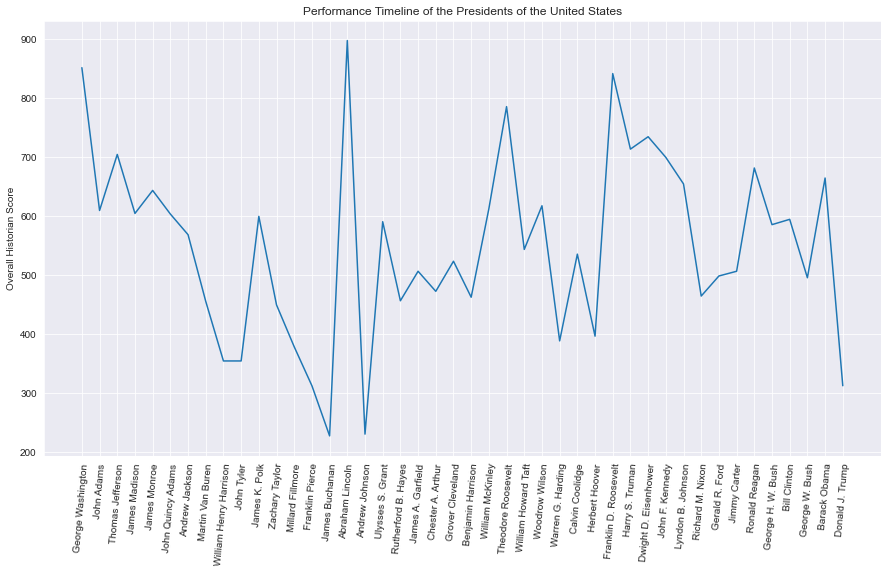

In [25]:
%matplotlib inline
sns.set_style('darkgrid')
plt.figure(figsize= (15,8))
plt.xticks(rotation=85)
sns.lineplot(x='President', y='Overall Historian Score', data=viz_df).set(
                xlabel='', title='Performance Timeline of the Presidents of the United States')

[Text(0, 0.5, 'Total Presidents'), Text(0.5, 1.0, 'Distribution of Scores')]

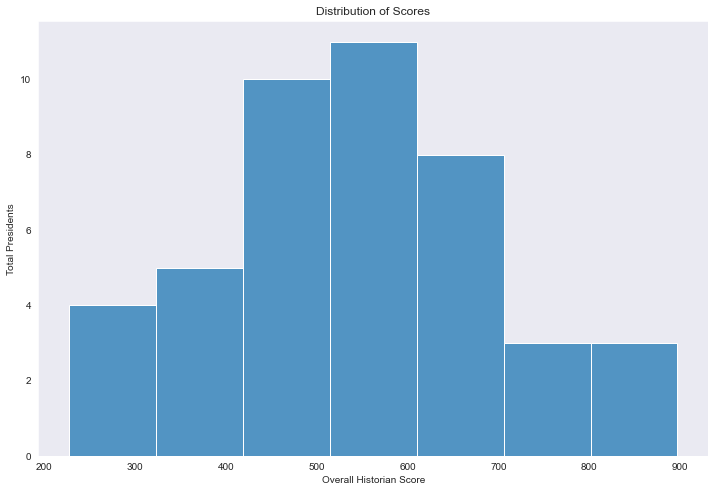

In [26]:
plt.figure(figsize=(12, 8))
sns.set_style('dark')
sns.histplot(viz_df['Overall Historian Score']).set(
                ylabel='Total Presidents', title="Distribution of Scores")

<Figure size 1080x576 with 0 Axes>

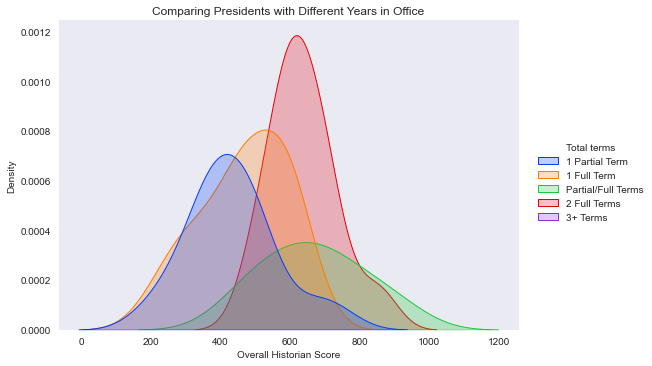

In [27]:
term_order = ['1 Partial Term', '1 Full Term', 'Partial/Full Terms', '2 Full Terms', '3+ Terms']

viz_df = ordered_cat_col(viz_df, term_order, 'Total terms')

plt.figure(figsize= (15,8))
sns.displot(data=viz_df, x='Overall Historian Score', hue='Total terms', kind='kde',
            palette='bright', height=5, aspect=1.5, fill=True, warn_singular=False).set(
                title='Comparing Presidents with Different Years in Office')

[Text(0.5, 1.0, 'Most Common Amount of Years in Office'),
 Text(0, 0.5, ''),
 Text(0.5, 0, '')]

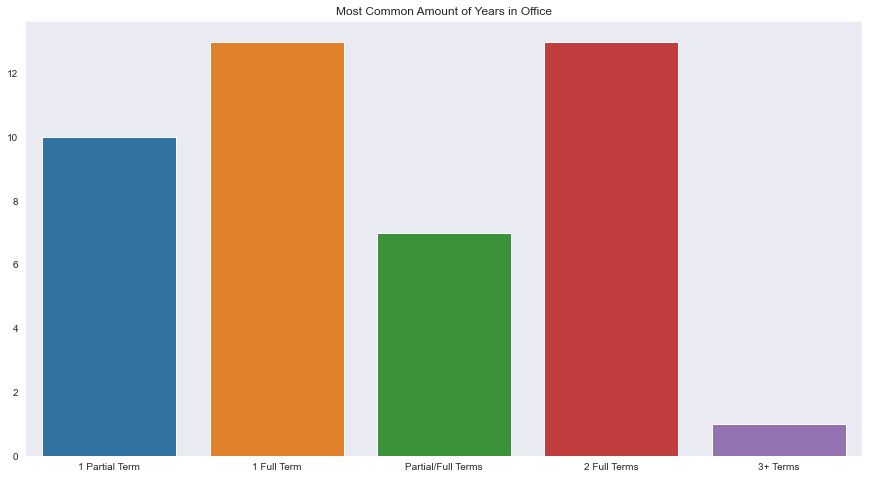

In [28]:
plt.figure(figsize= (15,8))
sns.countplot(x='Total terms', data=viz_df).set(
    title='Most Common Amount of Years in Office', ylabel='', xlabel='')

In [29]:
print('MOST AVERAGE US PRESIDENTS ACCORDING TO SURVEYED HISTORIANS (RANKED BY MOST AVERAGE):')

#Calcuate the average historian score
mean_score = int(viz_df['Overall Historian Score'].mean())

#Calculate the variance for each president
viz_df['Deviation from Average Score'] = viz_df['Overall Historian Score'].map(lambda x: abs(x - mean_score))

#Rank by most average
viz_df[(viz_df['Overall Historian Score'] > 500) & (viz_df['Overall Historian Score'] < 600)] \
        [['President ID', 'President', 'Party', 'Overall Historian Score', 'Deviation from Average Score', 'Total terms']] \
        .sort_values('Deviation from Average Score')

MOST AVERAGE US PRESIDENTS ACCORDING TO SURVEYED HISTORIANS (RANKED BY MOST AVERAGE):


,President ID,President,Party,Overall Historian Score,Deviation from Average Score,Total terms
25,27,William Howard Taft,Republican,543.0,6.0,1 Full Term
28,30,Calvin Coolidge,Republican,535.0,14.0,Partial/Full Terms
6,7,Andrew Jackson,Democratic,568.0,19.0,2 Full Terms
21,22,Grover Cleveland,Democratic,523.0,26.0,2 Full Terms
39,41,George H. W. Bush,Republican,585.0,36.0,1 Full Term
17,18,Ulysses S. Grant,Republican,590.0,41.0,2 Full Terms
19,20,James A. Garfield,Republican,506.0,43.0,1 Partial Term
37,39,Jimmy Carter,Democratic,506.0,43.0,1 Full Term
40,42,Bill Clinton,Democratic,594.0,45.0,2 Full Terms
10,11,James K. Polk,Democratic,599.0,50.0,1 Full Term


In [30]:
print('ABOVE AVERAGE US PRESIDENTS ACCORDING TO SURVEYED HISTORIANS:')

viz_df[(viz_df['Overall Historian Score'] > 600)] \
        [['President ID', 'President', 'Overall Historian Score', 'Party']] \
        .sort_values('Overall Historian Score', ascending=False)

ABOVE AVERAGE US PRESIDENTS ACCORDING TO SURVEYED HISTORIANS:


,President ID,President,Overall Historian Score,Party
15,16,Abraham Lincoln,897.0,Republican
0,1,George Washington,851.0,Unaffiliated
30,32,Franklin D. Roosevelt,841.0,Democratic
24,26,Theodore Roosevelt,785.0,Republican
32,34,Dwight D. Eisenhower,734.0,Republican
31,33,Harry S. Truman,713.0,Democratic
2,3,Thomas Jefferson,704.0,Democratic-Republican
33,35,John F. Kennedy,699.0,Democratic
38,40,Ronald Reagan,681.0,Republican
42,44,Barack Obama,664.0,Democratic


[Text(0, 0.5, 'Total Presidents'),
 Text(0.5, 1.0, 'Most Common Amount of Siblings')]

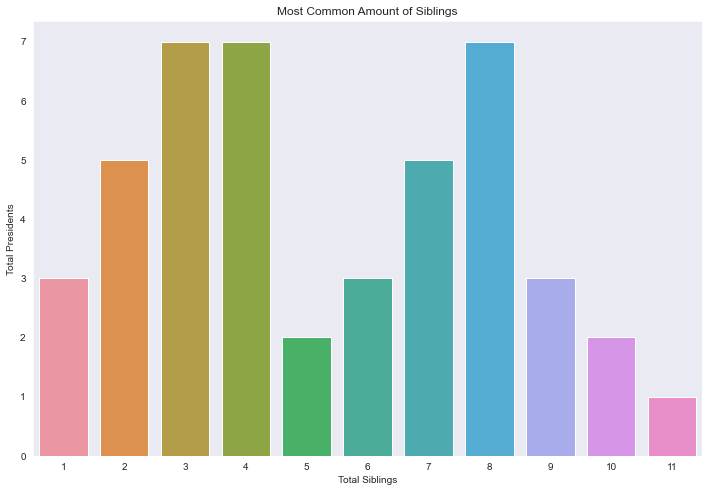

In [31]:
plt.figure(figsize= (12, 8))
sns.countplot(x='Total Siblings', data=joe_df).set(
                ylabel='Total Presidents', title='Most Common Amount of Siblings')

In [32]:
print('PRESIDENTS WITH MOST AMOUNT OF SIBLINGS:')

viz_df[(viz_df['Total Siblings'] >= 10)] \
        [['President ID', 'President', 'Total Siblings', 'Birth Order', 'Party', 'Overall Historian Score']] \
        .sort_values('Total Siblings', ascending=False)

PRESIDENTS WITH MOST AMOUNT OF SIBLINGS:


,President ID,President,Total Siblings,Birth Order,Party,Overall Historian Score
3,4,James Madison,11.0,First Born,Democratic-Republican,604.0
0,1,George Washington,10.0,Sixth Born,Unaffiliated,851.0
14,15,James Buchanan,10.0,Second Born,Democratic,227.0


[Text(0.5, 0, ''),
 Text(0, 0.5, 'Total Presidents'),
 Text(0.5, 1.0, 'Most Common Birth Orders')]

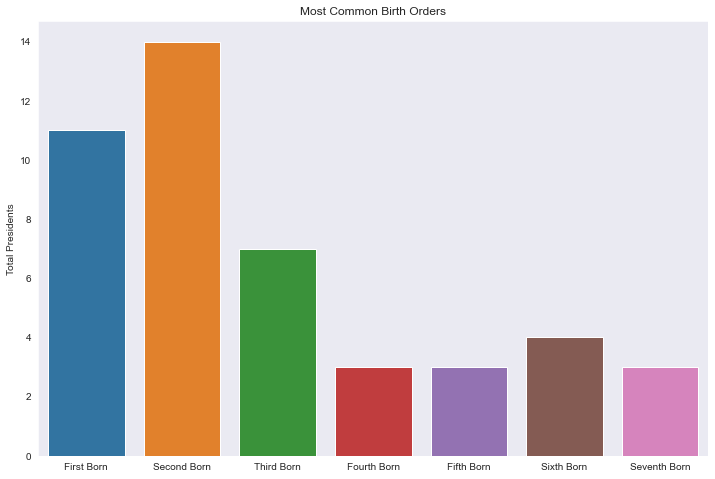

In [33]:
#Specify the sort order of categorical values
born_order = ['First Born', 'Second Born', 'Third Born','Fourth Born', 
            'Fifth Born', 'Sixth Born', 'Seventh Born']

viz_df = ordered_cat_col(viz_df, born_order, 'Birth Order')

plt.figure(figsize= (12, 8))
sns.countplot(x='Birth Order', data=joe_df, order=born_order).set(
                xlabel='', ylabel='Total Presidents', title='Most Common Birth Orders')

[Text(0, 0.5, ''),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Does Birth Order Have An Impact on Public Persuasion Score?')]

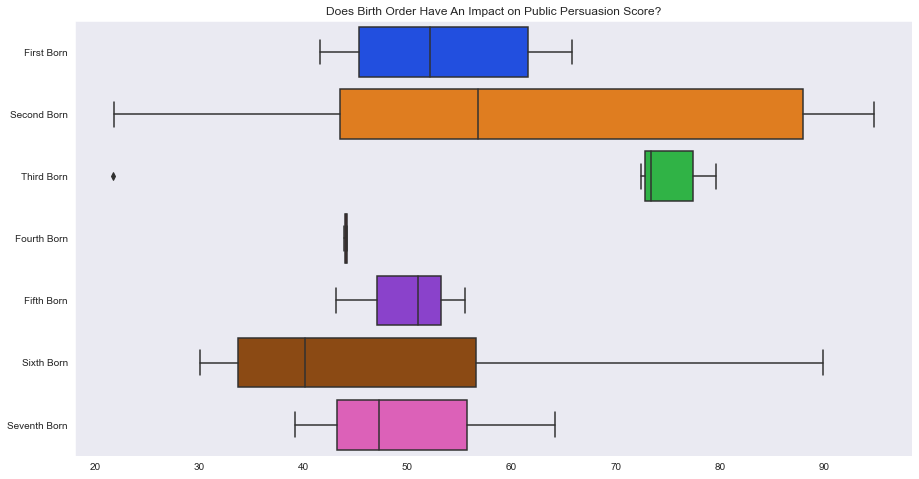

In [34]:
plt.figure(figsize= (15, 8))
sns.boxplot(x='Public Persuasion Score', y='Birth Order', data=viz_df, palette='bright').set(
                ylabel='', xlabel='', title='Does Birth Order Have An Impact on Public Persuasion Score?')

[Text(0, 0.5, 'Total Presidents'),
 Text(0.5, 1.0, 'Distribution of President Persuasion Scores')]

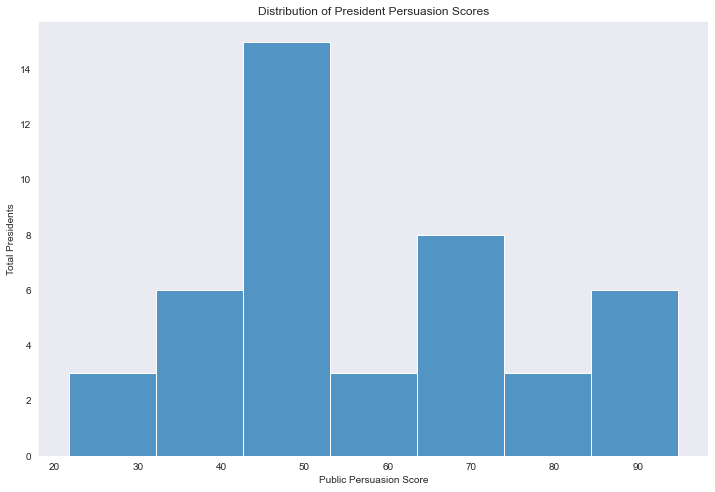

In [35]:
plt.figure(figsize=(12, 8))
sns.histplot(viz_df['Public Persuasion Score']).set(
                ylabel='Total Presidents', title="Distribution of President Persuasion Scores")

In [36]:
print('PRESIDENTS WITH ABOVE AVERAGE PUBLIC PERSUASION SKILLS')

mean_score = int(viz_df['Public Persuasion Score'].mean())


viz_df[(viz_df['Public Persuasion Score'] > mean_score + 10)] \
        [['President ID', 'President', 'Public Persuasion Score', 'Total Siblings', 'Birth Order', 'Party']] \
        .sort_values('Public Persuasion Score', ascending=False)

PRESIDENTS WITH ABOVE AVERAGE PUBLIC PERSUASION SKILLS


,President ID,President,Public Persuasion Score,Total Siblings,Birth Order,Party
30,32,Franklin D. Roosevelt,94.8,1.0,Second Born,Democratic
15,16,Abraham Lincoln,91.5,2.0,Second Born,Republican
24,26,Theodore Roosevelt,90.3,3.0,Second Born,Republican
0,1,George Washington,89.9,10.0,Sixth Born,Unaffiliated
38,40,Ronald Reagan,89.1,1.0,Second Born,Republican
33,35,John F. Kennedy,84.8,8.0,Second Born,Democratic
2,3,Thomas Jefferson,79.6,9.0,Third Born,Democratic-Republican
6,7,Andrew Jackson,78.6,2.0,Third Born,Democratic
42,44,Barack Obama,76.3,8.0,Third Born,Democratic
40,42,Bill Clinton,73.4,3.0,Third Born,Democratic


[Text(0.5, 0, ''),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Age at First Marriage'),
 (16.0, 51.45)]

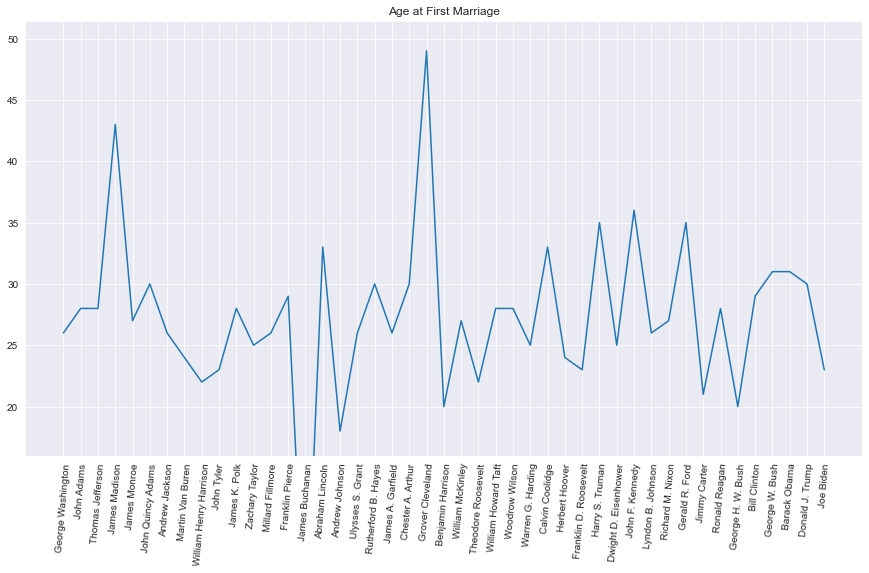

In [37]:
%matplotlib inline
sns.set_style('darkgrid')
plt.figure(figsize= (15,8))
plt.xticks(rotation=85)
sns.lineplot(x='President', y='Age at First Marriage', data=potusData).set(
                xlabel='', ylabel='', title='Age at First Marriage', ylim=(16))

Former president James Buchanan (15th) never married.

[Text(0, 0.5, 'Presidents'),
 Text(0.5, 0, 'Age'),
 Text(0.5, 1.0, 'Most Common Age that Presidents Get Married')]

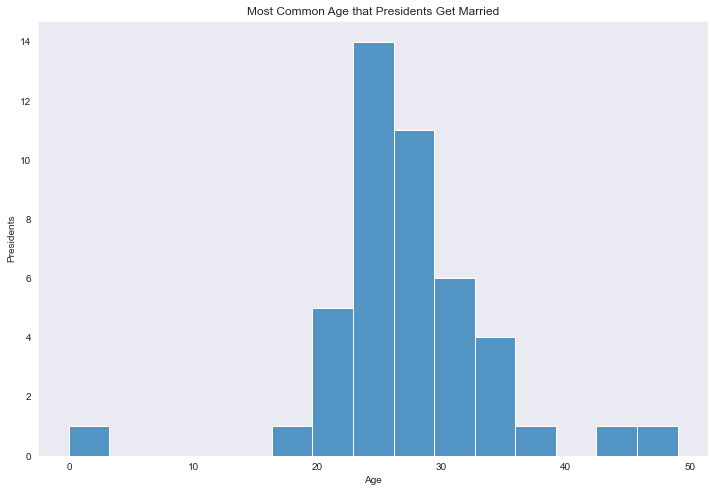

In [38]:
plt.figure(figsize=(12, 8))
sns.set_style('dark')
sns.histplot(potusData['Age at First Marriage']).set(
                ylabel='Presidents', xlabel='Age', title="Most Common Age that Presidents Get Married")

[Text(0.5, 0, ''),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Timeline: Amount of US Presidential Children')]

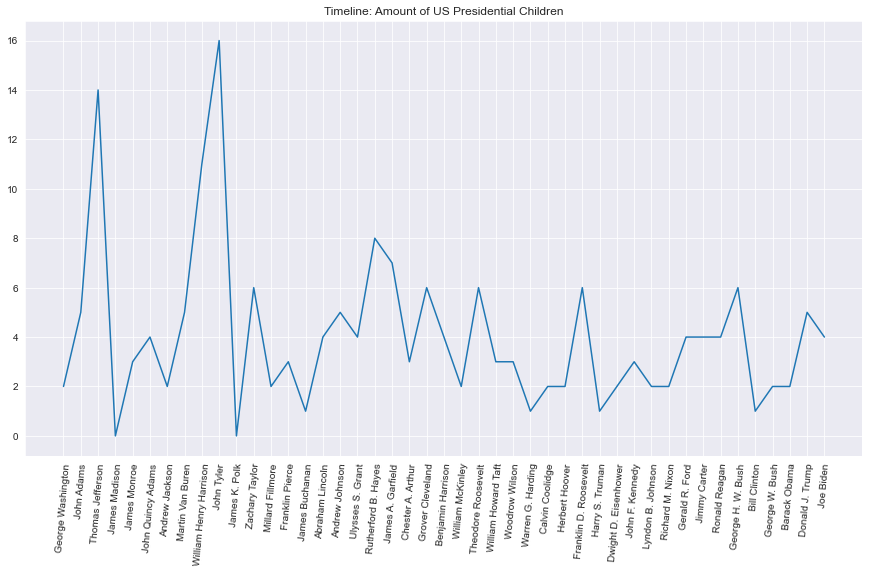

In [39]:
%matplotlib inline
sns.set_style('darkgrid')
plt.figure(figsize= (15,8))
plt.xticks(rotation=85)
sns.lineplot(x='President', y='Children', data=potusData).set(
                xlabel='', ylabel='', title='Timeline: Amount of US Presidential Children')

[Text(0, 0.5, 'Presidents'),
 Text(0.5, 0, 'Amount of Children'),
 Text(0.5, 1.0, 'Most Common Amount of Presidential Children')]

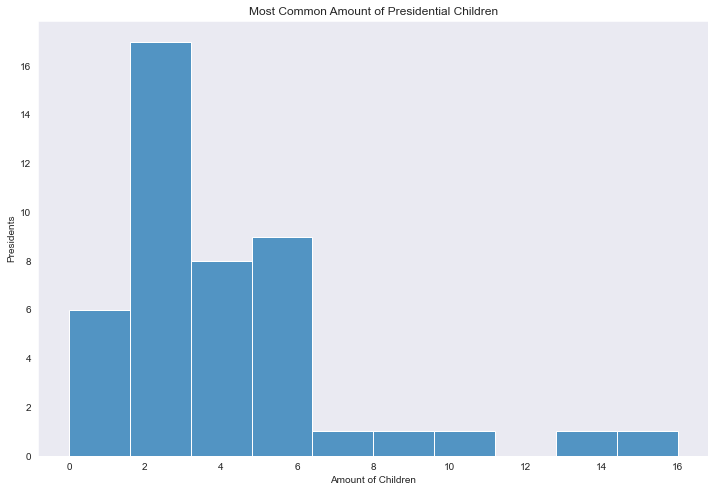

In [40]:
plt.figure(figsize=(12, 8))
sns.set_style('dark')
sns.histplot(potusData['Children']).set(
                ylabel='Presidents', xlabel='Amount of Children', 
                title="Most Common Amount of Presidential Children")

**Observations**: 

There are equal amounts of one full term presidents and two full term presidents. 

Presidents James Buchanan (15th) and Andrew Johnson (17th) are the least favorable by historians. In the order mentioned, Abraham Lincoln (16th), George Washington (1st), Franklin D. Roosevelt (32nd), and Theodore Roosevelt (26th) are the most favorable among surveyed historians.

Being a second-born child of three or four siblings will slightly increase your chances of becoming president. Unfortunately, the data does not specify if they grew up together. If you're not the second-born, try being the first-born instead, but you might be less persuasive in comparison (assuming you become US president).

If you find the love of your life in your twenties, it will slightly increase your chances of becoming president. Don't listen to this advice.

Like everyone else, presidents are having less children now. Having two children is the most popular option. No president has ever been an only child.

<h4>B) Comparing Democratic and Republican Parties</h4>

When analyzing republican and democratic parties, nineteen republican presidents and fifteen democratic presidents (excluding Joe Biden) historian scores are compared. Other presidents represented other parties.

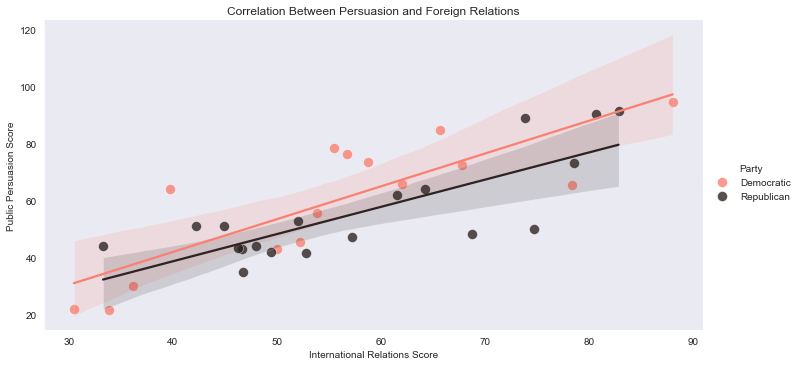

In [41]:
sns.lmplot(x='International Relations Score', y='Public Persuasion Score', 
            hue='Party', data=party_df, aspect=2,
            scatter_kws={'s': 100, 'linewidth': 0.5, 'edgecolor': 'white'}, palette='dark:salmon_r').set(
                title='Correlation Between Persuasion and Foreign Relations')

<Figure size 1080x576 with 0 Axes>

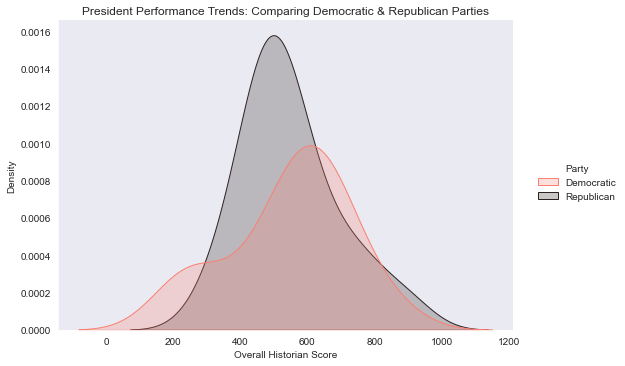

In [42]:
plt.figure(figsize= (15,8))
sns.displot(data=party_df, x='Overall Historian Score', hue='Party', kind='kde', 
            palette='dark:salmon_r', height=5, aspect=1.5, fill=True, warn_singular=False).set(
                title='President Performance Trends: Comparing Democratic & Republican Parties')

[Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Timeline: Comparing Democratic & Republican Parties')]

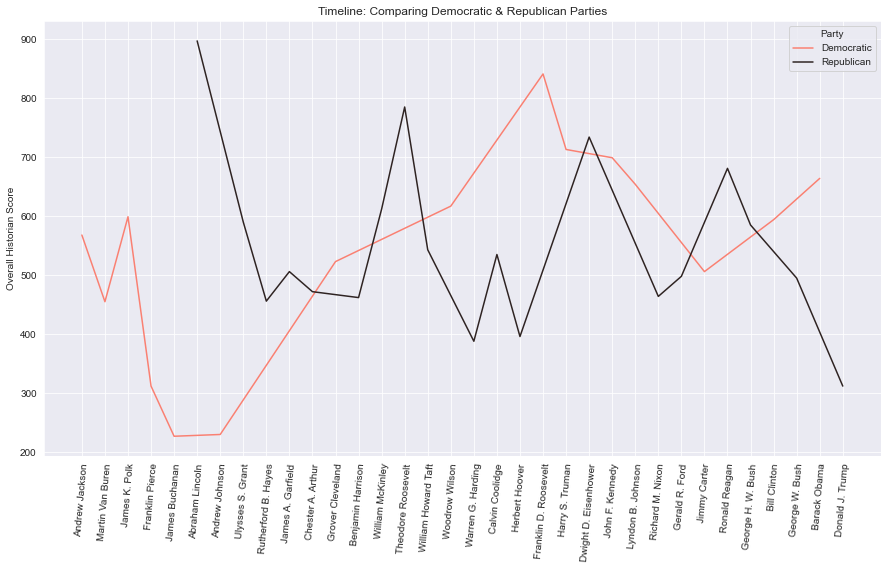

In [43]:
%matplotlib inline
sns.set_style('darkgrid')
plt.figure(figsize= (15,8))
plt.xticks(rotation=85)
sns.lineplot(x='President', y='Overall Historian Score', data=party_df, hue='Party',
            palette='dark:salmon_r').set(xlabel='', title='Timeline: Comparing Democratic & Republican Parties')

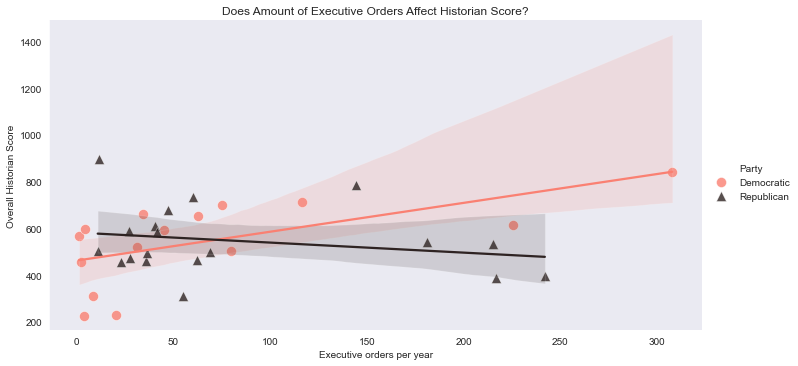

In [44]:
sns.set_style('dark')
sns.lmplot(x='Executive orders per year', y='Overall Historian Score', hue='Party', data=party_df,
                markers=['o','^'], aspect=2, palette='dark:salmon_r',
                scatter_kws={'s': 100, 'linewidth': 0.5, 'edgecolor': 'white'}).set(
                    title='Does Amount of Executive Orders Affect Historian Score?')

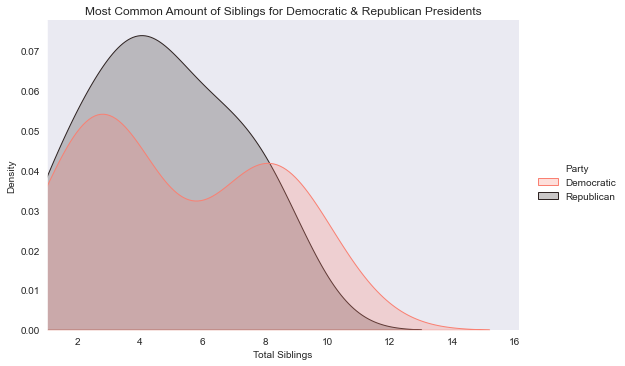

In [45]:
sns.displot(data=joe_party, x='Total Siblings', hue='Party', kind='kde', 
            palette='dark:salmon_r', height=5, aspect=1.5, fill=True, warn_singular=False).set(
                xlim=(1), title='Most Common Amount of Siblings for Democratic & Republican Presidents')

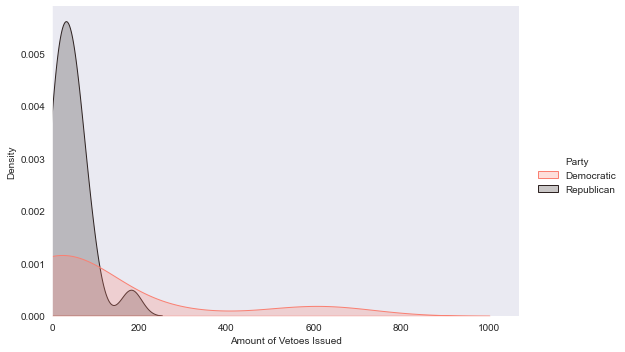

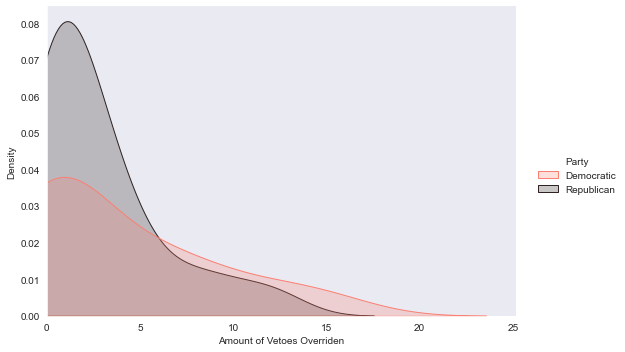

In [46]:
sns.displot(data=party_df, x='Vetoes', hue='Party', kind='kde', 
            palette='dark:salmon_r', height=5, aspect=1.5, fill=True, warn_singular=False).set(
                xlim=(0), xlabel='Amount of Vetoes Issued')

sns.displot(data=party_df, x='Vetoes Overridden', hue='Party', kind='kde', 
            palette='dark:salmon_r', height=5, aspect=1.5, fill=True, warn_singular=False).set(
                xlim=(0), xlabel='Amount of Vetoes Overriden')

**Observations**:

Unsurprisingly, there is a positive correlation between foreign relations and persuasion skills. 

Executive orders of democratic presidents are more likely to contribute to a higher historian score. The Great Depression and World War 2, caused Franklin D. Roosevelt (32nd) to be an outlier and might be skewing the results in favor of the democratic presidents given the vast amount of executive orders during times of crisis. However, republican president Abraham Lincoln (16th) also faced times of crisis yet he issued around eleven executive orders per year compared to Franklin D. Roosevelt's (32nd) one hundred forty-four executive orders per year.

Republican presidents are less likely to veto a decision made by Congress and less likely to have a veto overriden by Congress.

<h2>Future Research Recomendations</h2>

Once a president has left the office, it takes time to get a full asssesment of the presidency and it's impact on the nation. One of the goals of the Presidential Historians Survey is to have a window into what historians are thinking soon after an administration ends and if there are any changes in a presidents historians score years later after additional surveys ([source](https://www.c-span.org/video/?513077-1/span-announces-results-2021-presidential-historians-survey)). It's always best to wait 25 years until judging a president because that's when the National Archives releases documents through the Freedom of Information Act.

Historian scores can also be compared with Gross Domestic Product (GDP) growth and population growth between each president.

We can also attempt to determine if there are significant correlations between presidents who divorced, remarried, or spouse passed away. Also, gathering demographic information on each of the first ladies and presidential children might reveal trends into what makes a good president.